In [1]:
pip install -q -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

from statsforecast import StatsForecast

import time
from statsforecast.models import (
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive,
    AutoARIMA,
    AutoETS,
    Naive
)
from utilsforecast.losses import *
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from utilsforecast.evaluation import evaluate

from functools import partial
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoModelForCausalLM
from chronos import BaseChronosPipeline
import scipy.stats as stats 

import lightgbm as lgb
from sklearn.linear_model import LinearRegression

from importlib import reload
import utils
reload(utils)
from utils import prepare_data, TimeMoEPredictor, ChronosPredictor, LLM, wape, ProphetForecast
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences

from statsforecast.utils import ConformalIntervals

import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

intervals = ConformalIntervals(h=3, n_windows=5)



/Users/xcx7787/m4_tests/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-12 14:55:13,446	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-12-12 14:55:13,522	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Prepare data

In [3]:
#train, test = prepare_data(sample_size=1000,series_cutoff=12*2,min_series_length=12*2)

train = pd.read_csv("train.csv",parse_dates=['ds'])
test = pd.read_csv("test.csv",parse_dates=['ds'])

In [4]:
# Create a list of models and instantiation parameters
season_length = 12

models_classes_stats = [
    DOT(season_length=season_length),
    AutoARIMA(prediction_intervals=intervals),
    AutoETS(prediction_intervals=intervals),
    Naive(prediction_intervals=intervals)
]

model_classes_neural = [
    NBEATS(h=3, input_size=10,
               stack_types = ['identity', 'trend', 'seasonality'],
            )
]

model_classes_ml = [
    lgb.LGBMRegressor(random_state=0, verbosity=-1),
    LinearRegression(),
]

model_classes_custom = [
    TimeMoEPredictor(input_length=12*2,device="cpu"),
    ChronosPredictor(input_length=12*2,device="mps"),
    #ProphetForecast( train,  weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=True, interval_width=0.95 )
    ]


Seed set to 1
/Users/xcx7787/m4_tests/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
model_wrappers = {}
model_names = []

neural = False
stats = False
ML = False
custom = True

if ML:
    for model in model_classes_ml:
        model_name = str(model).split("(")[0]
        model_names.append(model_name)
        model_wrappers[model_name]=(
            MLForecast(
                models=model,
                freq='ME',
                #lags=[1,2,3],
                #lag_transforms={
                #    1: [ExpandingMean(),RollingMean(window_size=12),RollingMean(window_size=3),RollingMean(window_size=6),RollingMean(window_size=12)],        
                #},
                date_features=['dayofweek'],
                target_transforms=[Differences([1])],
            )
        )

if custom:
    for model in model_classes_custom:
        model_name = str(type(model).__name__)
        model_names.append(model_name)
        model_wrappers[model_name] = model

if neural:
    for model in model_classes_neural:
        model_name = str(model)
        model_names.append(model_name)
        model_wrappers[model_name]=(
            NeuralForecast( 
                models=[model],
                freq='ME'
            )
        )    

if stats:
    for model in models_classes_stats:
        model_name = str(model)
        model_names.append(model_name)
        model_wrappers[model_name]=(
            StatsForecast( 
                models=[model],
                freq="ME", 
                fallback_model = SeasonalNaive(season_length=12),
                n_jobs=-1,
            )
        )    


In [6]:
fit_times = {}

for model_name, model in model_wrappers.items():
    if isinstance(model, MLForecast):
        start = time.time()
        model.fit(df=train, prediction_intervals=intervals )
        fit_times[model_name] = time.time()-start

    elif isinstance(model, StatsForecast) or isinstance(model, NeuralForecast) or isinstance(model, ProphetForecast):
        start = time.time()
        model.fit(df=train )
        fit_times[model_name] = time.time()-start    

In [7]:
forecast_dict = {}
forecast_times = {}

levels = [95]

def add_model(forecasts,model_name):
    forecast_dict[model_name] = forecasts
    
for model_name, model in model_wrappers.items():
    print(model)
    
    start = time.time()

    if isinstance(model, NeuralForecast):
        add_model(model.predict().reset_index(),model_name)
    elif (isinstance(model,StatsForecast)) or (isinstance(model,MLForecast)):
        add_model(model.predict(h=3,level=levels),model_name)
    elif isinstance(model, ProphetForecast):
        add_model(model.predict(test,h=3),model_name)      
    else:
        add_model(model.predict(train,test,h=3),model_name)
        fit_times[model_name] = time.time()-start

    forecast_times[model_name] = time.time()-start


In [8]:
forecast_times

{'TimeMoEPredictor': 4.894021987915039, 'ChronosPredictor': 0.5085999965667725}

In [9]:
train

,unique_id,y,ds
0,M10000,2170.0,2015-04-30 12:00:00
1,M10000,2470.0,2015-05-31 12:00:00
2,M10000,2490.0,2015-06-30 12:00:00
3,M10000,2680.0,2015-07-31 12:00:00
4,M10000,2800.0,2015-08-31 12:00:00
...,...,...,...
20344,M9964,700.0,2016-08-31 12:00:00
20345,M9964,630.0,2016-09-30 12:00:00
20346,M9964,630.0,2016-10-31 12:00:00
20347,M9964,610.0,2016-11-30 12:00:00


In [10]:
weights = (
    train
        .groupby("unique_id",)["y"]
        .sum()
        .rename("weights")
)

weights = weights/weights.sum()

In [11]:
metrics = [
    mape,
    wape,
    rmse,
    partial(mase, seasonality=12),
    partial(rmsse, seasonality=12),
]

In [12]:
test = test.reset_index()

for name,forecast in forecast_dict.items():
    test = test.merge(forecast, on = ["ds","unique_id"],how="inner")

In [30]:
test

,index,unique_id,y,ds,TimeMoEPredictor,ChronosPredictor,ChronosPredictor-lo-95,ChronosPredictor-hi-95
0,0,M10000,2410.0,2017-01-31 12:00:00,2251.396729,2259.816162,1983.723999,2558.836670
1,1,M10000,2540.0,2017-02-28 12:00:00,2218.101807,2216.154541,1871.880859,2610.603760
2,2,M10000,2890.0,2017-03-31 12:00:00,2223.757324,2245.966797,1862.514404,2697.308105
3,3,M10127,1118.0,2016-08-31 12:00:00,1093.442017,1099.711914,1081.859985,1113.339478
4,4,M10127,1107.0,2016-09-30 12:00:00,1090.223389,1098.119873,1074.377441,1116.534912
...,...,...,...,...,...,...,...,...
2902,2902,M9942,1480.0,2017-02-28 12:00:00,1743.900269,1707.601196,1507.394409,1930.325439
2903,2903,M9942,1380.0,2017-03-31 12:00:00,1768.773071,1728.366821,1478.653198,2006.303345
2904,2904,M9964,460.0,2017-01-31 12:00:00,538.010864,513.980835,451.625427,598.219116
2905,2905,M9964,470.0,2017-02-28 12:00:00,558.426758,518.163330,432.705933,638.817688


In [35]:
(
    test
        .filter(regex='95|index')
        .melt(id_vars="index")
        .assign(
            model=lambda x: x["variable"].str.split("-", n=1, expand=True)[0],
            d=lambda x: x["variable"].str.split("-", n=1, expand=True)[1]
        )
        .pivot(index = ["index","model"], columns="d",values="value")
        .assign(
            width = lambda x : x["hi-95"]-x["lo-95"]
        )
        .groupby(["model"])["width"]
        .median()
        .sort_values()
)

model
ChronosPredictor    519.095703
Name: width, dtype: float32

In [14]:
eval = evaluate(test, metrics=metrics, train_df=train)

In [15]:
eval[eval["metric"]=='wape']

,unique_id,metric,index,TimeMoEPredictor,ChronosPredictor
969,M10000,wape,2612.333333,0.171328,0.166330
970,M10127,wape,277.000000,0.019411,0.013541
971,M1013,wape,339.000000,0.191381,0.118665
972,M10176,wape,335.536667,0.070496,0.068905
973,M10280,wape,577.564103,0.015964,0.007454
...,...,...,...,...,...
1933,M9825,wape,0.045051,0.086110,0.124884
1934,M983,wape,1.039595,0.043403,0.017168
1935,M9922,wape,0.717144,0.130402,0.173734
1936,M9942,wape,0.483115,0.139002,0.124617


In [16]:
eval.drop(columns=["index"]).set_index(["unique_id","metric" ]).stack().reset_index().set_index(["unique_id",'metric', 'level_2']).unstack(level=1).corr()

0                                        
metric        mape      mase      rmse     rmsse      wape
  metric                                                  
0 mape    1.000000  0.108277  0.367462  0.125143  0.392297
  mase    0.108277  1.000000  0.300569  0.967510  0.272938
  rmse    0.367462  0.300569  1.000000  0.349021  0.831007
  rmsse   0.125143  0.967510  0.349021  1.000000  0.306344
  wape    0.392297  0.272938  0.831007  0.306344  1.000000

In [17]:
eval.drop(columns=["index"]).set_index(["unique_id","metric" ]).stack().reset_index().set_index(["unique_id",'metric', 'level_2']).unstack(level=1).describe()

0                                                     
metric         mape         mase          rmse        rmsse         wape
count   1938.000000  1938.000000   1938.000000  1938.000000  1938.000000
mean       0.138424     0.915266    500.718042     0.856542     0.110407
std        0.428022     1.415314   1197.920544     1.214233     0.226354
min        0.000036     0.008058      0.482748     0.008329     0.000036
25%        0.015215     0.281672     60.946116     0.289419     0.015294
50%        0.040834     0.583586    169.536031     0.564172     0.041124
75%        0.124034     1.076856    442.487973     1.016040     0.121661
max        7.637910    22.812109  19339.824513    17.118554     3.478477

In [18]:
metrics = eval.drop(columns="index").set_index(["unique_id","metric"]).stack().rename_axis(index={None: 'Model'}).rename("value")

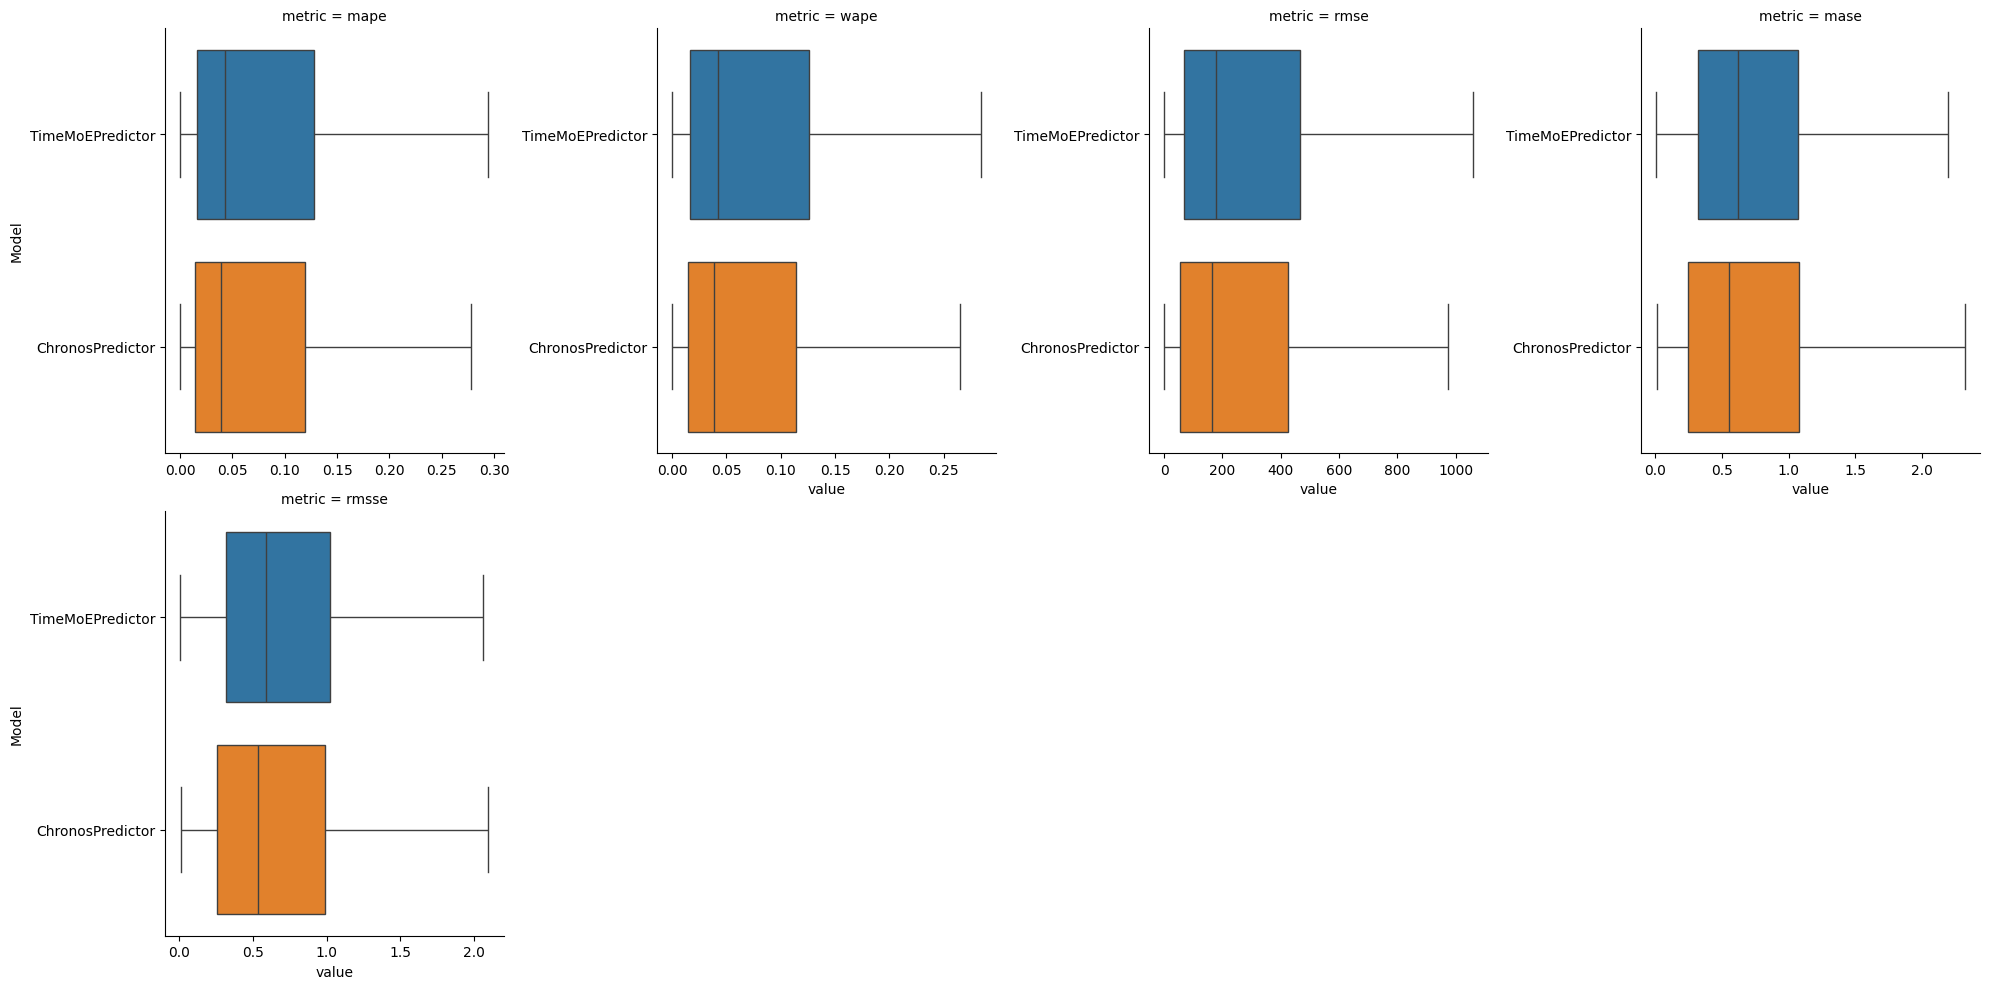

In [19]:
sns.catplot(
    data=metrics.reset_index(), x='value', y='Model',hue="Model",sharey=False,sharex=False,showfliers=False,
    col='metric', kind='box', col_wrap=4
)

In [20]:
fit_times = pd.DataFrame.from_records([fit_times])
forecast_times = pd.DataFrame.from_records([forecast_times])

In [21]:
fit_times = fit_times.melt(var_name="Model",value_name="fit").set_index("Model")

forecast_times = forecast_times.melt(var_name="Model",value_name="forecast").set_index("Model")

In [22]:
metrics.groupby(level=[1,2]).median().unstack()

Model,ChronosPredictor,TimeMoEPredictor
metric,,
mape,0.038643,0.042595
mase,0.551195,0.624361
rmse,162.749905,177.878785
rmsse,0.535343,0.588745
wape,0.038849,0.042660


In [23]:
md = metrics.groupby(level=[1,2]).median().to_frame().join(fit_times).join(forecast_times).set_index("value",append=True).stack().rename_axis(index={None: 'time'}).rename("time_value").reset_index()

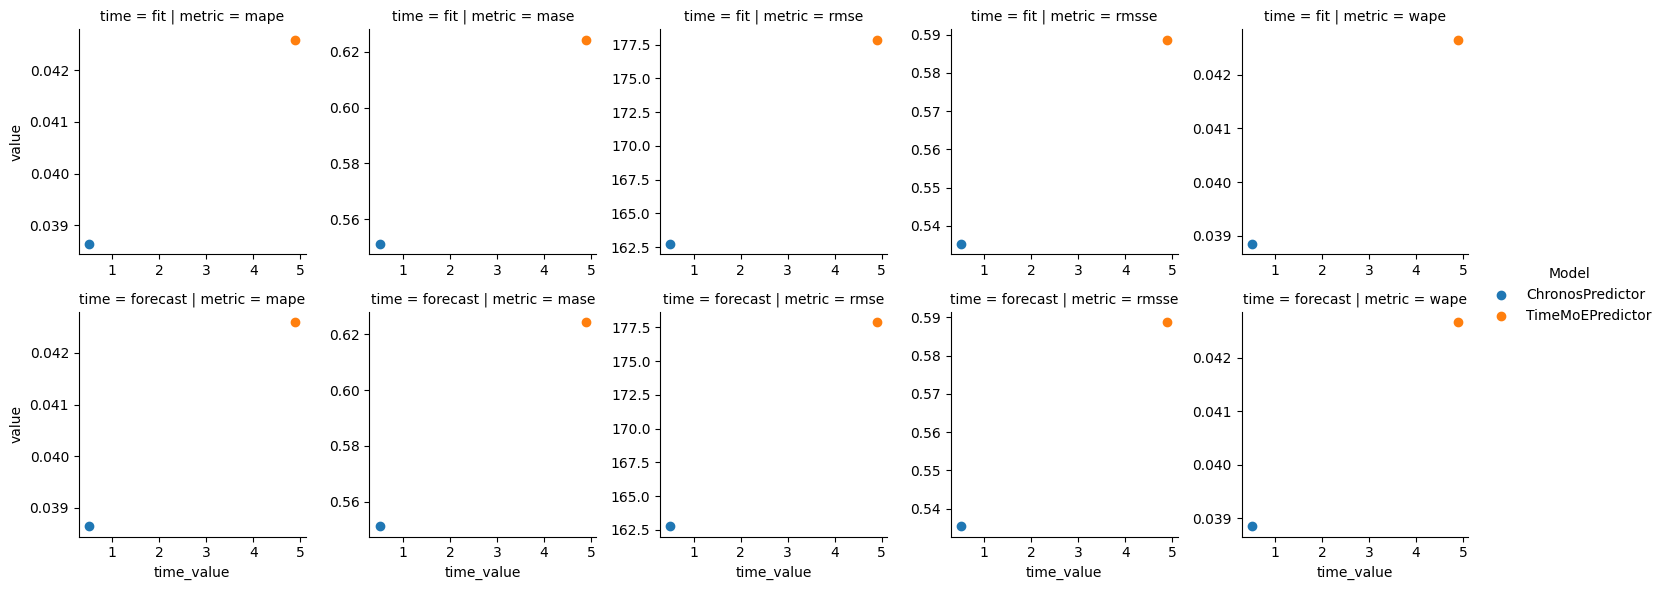

In [24]:
g = sns.FacetGrid(md, row= "time", col="metric", hue = "Model",sharey=False,sharex=False)
g = g.map(plt.scatter, "time_value", "value")
g.add_legend()

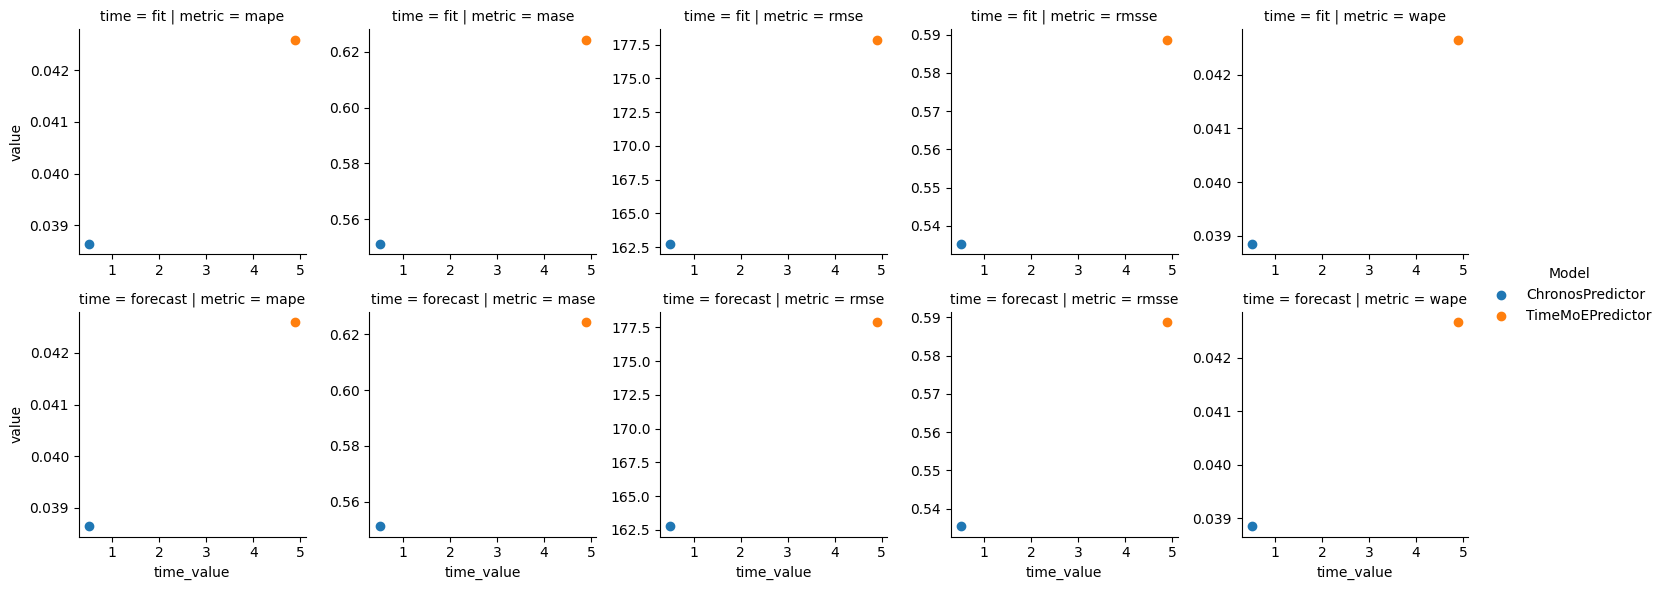

In [25]:
g = sns.FacetGrid(md[md["Model"]!="ProphetForecast"], row= "time", col="metric", hue = "Model",sharey=False,sharex=False)
g = g.map(plt.scatter, "time_value", "value")
g.add_legend()

In [26]:
(
    metrics
        #[metrics.index.get_level_values(level=1).isin(["rmsse","rmse","mape","wape"])]
        .reset_index().merge(weights, on = "unique_id")
        .assign(metric = lambda x : "w"+x["metric"],
                value = lambda x : x.value*x.weights
                )
        .groupby(["metric","Model"])["value"]
        .sum()
        .sort_values()
        .unstack(level=0)
        .reset_index()
        .sort_values(by="wrmsse")
)

metric,Model,wmape,wmase,wrmse,wrmsse,wwape
0,ChronosPredictor,0.119914,0.882660,656.854223,0.836073,0.096924
1,TimeMoEPredictor,0.124210,0.910937,660.646555,0.856302,0.094421


In [27]:
df = metrics.unstack(level=1).reset_index().drop(columns=["unique_id"])

In [28]:
from itertools import product
from scipy import stats
import pandas as pd

cols = df.columns.difference(['Model'])

g = df.groupby('Model')[cols]

out = pd.concat({(a, b): pd.DataFrame(stats.ttest_rel(g.get_group(a), g.get_group(b),alternative="less"),
                                      columns=cols, index=['statistic', 'pvalue'])
                 for a, b in product(df['Model'].unique(), repeat=2)
                }, names=['product1', 'product2'])


<Axes: xlabel='None-product2', ylabel='product1-metric'>

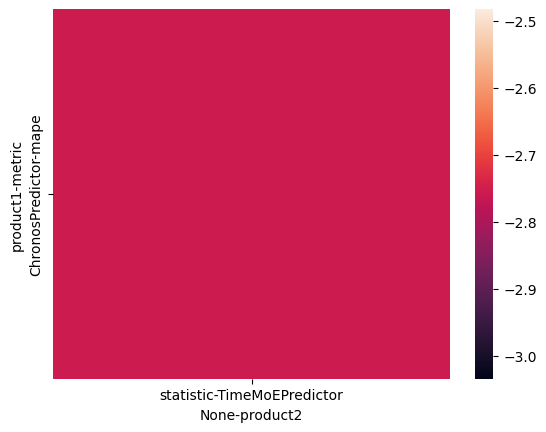

In [29]:
sns.heatmap(out.stack().unstack(level=2).loc[lambda x : x.pvalue <0.05].drop(columns="pvalue").unstack(level=1))